# DTSA 5511: Introduction to Deep Learning  

## Week 4: Natural Language Processing with Disaster Tweets - Kaggle Mini-Project

## Overview, Purpose, and Data  

### Project Challenge  

For this challenge, we are tasked with creating a machine learning model which analyzes tweets from Twitter and classifying which are about real disasters.  

In a real world application a model of this nature could prove useful in identifying disasters as they are occurring. In our connected world people are often quick to take to social media about events as they unfold. A properly trained ML model could review tweets and identify when a real disaster was unfolding.  

### Data Source  

Data for this project was obtained from the [Kaggle NLP with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/overview) competition.  

### Data Import Tasks

In [1]:
# Initial Setup Steps
# Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, TextVectorization 
from tensorflow.keras.layers import Embedding, GRU, LSTM
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam


In [2]:
# Data import steps
tweet_training_data = pd.read_csv("./Data/nlp-getting-started/train.csv")
tweet_test_data = pd.read_csv("./Data/nlp-getting-started/test.csv")

In [3]:
# View first 5 rows of training data
tweet_training_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Explore basic data information
# Explore basic data information:
print(f"The training data set contains {tweet_training_data.shape[0]} samples.")
print(f"The testing data set contains {tweet_test_data.shape[0]} samples.")
print(f"We are provided the following information: {', '.join(tweet_training_data.columns)}")
print("Data types are as follows:")
print(tweet_training_data.dtypes)

The training data set contains 7613 samples.
The testing data set contains 3263 samples.
We are provided the following information: id, keyword, location, text, target
Data types are as follows:
id           int64
keyword     object
location    object
text        object
target       int64
dtype: object


## Exploratory Data Analysis  

### Disctribution of Classes  

For this data, we are seeking to determine whether the tweet is about a real natural distaster or not. Our training data set contains this information in target column noting integer 0 if it is __Not__ about a natural disaster or integer 1 if it is. Our data contains tweets distributed as follows.

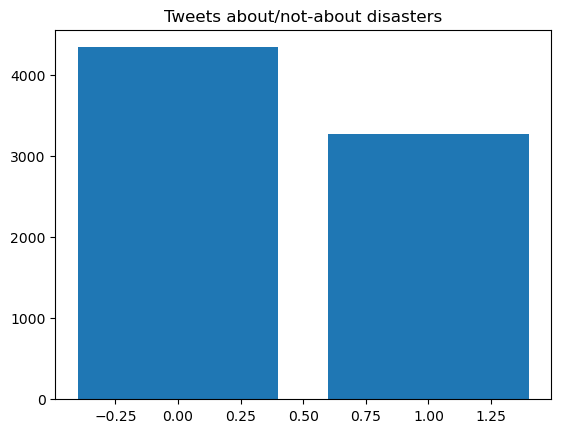

Our training data contains 3271 tweets about natural disasters and 4342 not about disasters.


In [5]:
# Explore distribution of classes
count = tweet_training_data['target'].value_counts()
plt.bar(count.index, count.values)
plt.title('Tweets about/not-about disasters')
plt.show()
print(f"Our training data contains {count[1]} tweets about natural disasters and {count[0]} not about disasters.")

Next we will take a look at the length of tweets we have. This will not necessarily be 100% accurate as we have done no cleaning, but it should give us an idea.

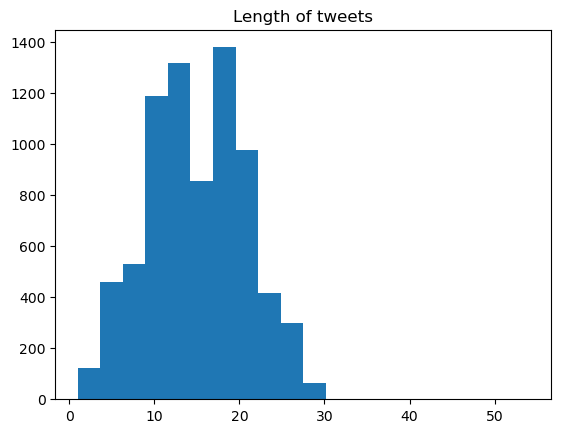

Longest tweet length: 54.
Shortest tweet length: 1.


In [6]:
# Length of tweets
len_of_tweets = list(map(len, tweet_training_data.text.str.split(' ')))
plt.hist(len_of_tweets, bins=20)
plt.title('Length of tweets')
plt.show()
print(f"Longest tweet length: {max(len_of_tweets)}.")
print(f"Shortest tweet length: {min(len_of_tweets)}.")

Finally, I wanted to show a few examples of tweets about and not disasters.

In [7]:
# Example tweets:
print("Tweets about disasters:")
print("-----------------------")
print(f"- {tweet_training_data.text[0]}")
print(f"- {tweet_training_data.text[1]}")
print("\n")
print("Tweets not about disasters:")
print("-----------------------")
print(f"- {tweet_training_data.text[15]}")
print(f"- {tweet_training_data.text[16]}")

Tweets about disasters:
-----------------------
- Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
- Forest fire near La Ronge Sask. Canada


Tweets not about disasters:
-----------------------
- What's up man?
- I love fruits


### Cleaning and Preprocessing  

First, I will use ID to determine if there are any duplicate data.

In [8]:
# Check for duplicates
print(f"There are {(tweet_training_data['id'].value_counts() > 1).sum()} values in our training set with duplicate values.")
print(f"There are {(tweet_test_data['id'].value_counts() > 1).sum()} values in our testing set with duplicate values.")

There are 0 values in our training set with duplicate values.
There are 0 values in our testing set with duplicate values.


Next, for our purposes we will only be using the text of these tweets in our model. As such, we can drop the id, location, and keyword columns.

In [ ]:
# Drop fields not needed
tweet_training_data = tweet_training_data.drop(['id', 'keyword', 'location'], axis=1)
tweet_test_data = tweet_test_data.drop(['keyword', 'location'], axis=1)

Cleaning of the actual content of the tweets will be required. This will include things like stripping out punctuation and normalizing cases. While this may be considered in the realm of data cleaning, I will perform it within my models using a TextVectorization layer of Keras.

### Preprocessing and GloVe  

In a prior project, I used TF-IDF for processing word embeddings. In this scenario, I will attempt to use GloVe.  In order to perform analysis on text, we first have to turn it in to a vector by tokenizing it. This will transform it into a numerical representation. While this will allow us to directly compare whether two tweets are similar by looking for the same words, it won't allow us to compare similarity by comparing similar words, like cat and tiger. This is where GloVe comes in.  

GloVe is a word vector technique that compares sequences of words with pre-trained statistics to determine how similar words are. What is unique about GloVe is that instead of comparing against the local sample that you have, you can compare word vectors against vectors trained on large samples of text. This will generally give you a broader representation, though of note, if your samples are fairly unique, you may lose some of the ability to detect that specificity.

In [16]:
# Perform Text Vectorization to get a list of vocabulary
text_vectorization = TextVectorization(
    max_tokens=5000,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
    output_sequence_length=max(len_of_tweets)
)

text_vectorization.adapt(tweet_training_data.text)

# Create a vocabulary dictionary which maps words to integer values
vocab_dict = {key:val for key,val in zip(text_vectorization.get_vocabulary(), range(len(text_vectorization.get_vocabulary())))}

print(list(vocab_dict.items())[:10])

2023-04-20 17:28:46.488964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[('', 0), ('[UNK]', 1), ('the', 2), ('a', 3), ('in', 4), ('to', 5), ('of', 6), ('and', 7), ('i', 8), ('is', 9)]


In [18]:
# GloVe embedding
glove_path = "./glove.6B/glove.6B.200d.txt"
glove_dict = {}
with open(glove_path) as f:
    for line in f:
        vals = line.split()
        word = vals[0]
        coefs = vals[1:]
        glove_dict[word] = np.asarray(coefs, dtype="float32")

embedding_matrix = np.zeros(shape=(len(vocab_dict)+1, 200))
for word, index in vocab_dict.items():
    embedding_vector = glove_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Architecture and Modeling  

For this assignment, I will start with the most basic version of RNN, the simple RNN from Keras. This will give a baseline to work with and compare more advanced models to.  

Once I have a the simple model, I will move on to the LSTM model discussed in class. As we learned, this is a more advanced model which leveraged gating mechanisms to maintain a mix of long and short term memory typically enabling much better predictions.

Both of these models should function in this case as tweets are not longer 54 words. As we get more text involved, the simple RNN model runs into issues that are resolved by more advanced models.

### Model 1: SimpleRNN

In [20]:
model_simplernn = Sequential()
model_simplernn.add(keras.Input(shape=(1,), dtype=tf.string))
model_simplernn.add(text_vectorization)
model_simplernn.add(Embedding(
    input_dim=len(vocab_dict) + 1,
    output_dim=200,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False
))
model_simplernn.add(SimpleRNN(units=128))
model_simplernn.add(Dense(1, activation="sigmoid"))
model_simplernn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 54)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 54, 200)           1000200   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               42112     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,042,441
Trainable params: 42,241
Non-trainable params: 1,000,200
_________________________________________________________________


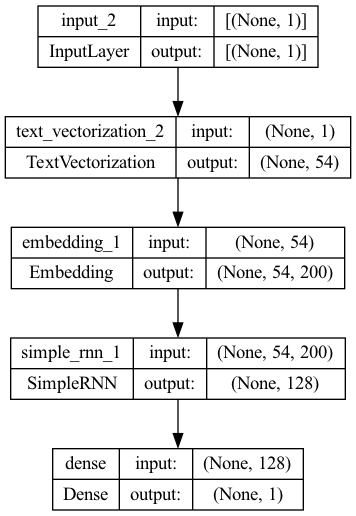

In [21]:
keras.utils.plot_model(model_simplernn, show_shapes=True)

In [22]:
# Compile and fit model_simplernn
model_simplernn.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

simplernn_results = model_simplernn.fit(tweet_training_data.text, tweet_training_data.target, validation_split=0.2, epochs=5)

Epoch 1/5


2023-04-20 17:39:16.255622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - ETA: 0s - loss: 0.6157 - accuracy: 0.6819

2023-04-20 17:41:26.652980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - 136s 708ms/step - loss: 0.6157 - accuracy: 0.6819 - val_loss: 0.7118 - val_accuracy: 0.5010
Epoch 2/5
191/191 [==============================] - 131s 685ms/step - loss: 0.6934 - accuracy: 0.5438 - val_loss: 0.6892 - val_accuracy: 0.4970
Epoch 3/5
191/191 [==============================] - 131s 684ms/step - loss: 0.6879 - accuracy: 0.5496 - val_loss: 0.6921 - val_accuracy: 0.5345
Epoch 4/5
191/191 [==============================] - 131s 684ms/step - loss: 0.6873 - accuracy: 0.5667 - val_loss: 0.6942 - val_accuracy: 0.5345
Epoch 5/5
191/191 [==============================] - 131s 686ms/step - loss: 0.6820 - accuracy: 0.5732 - val_loss: 0.6909 - val_accuracy: 0.5345


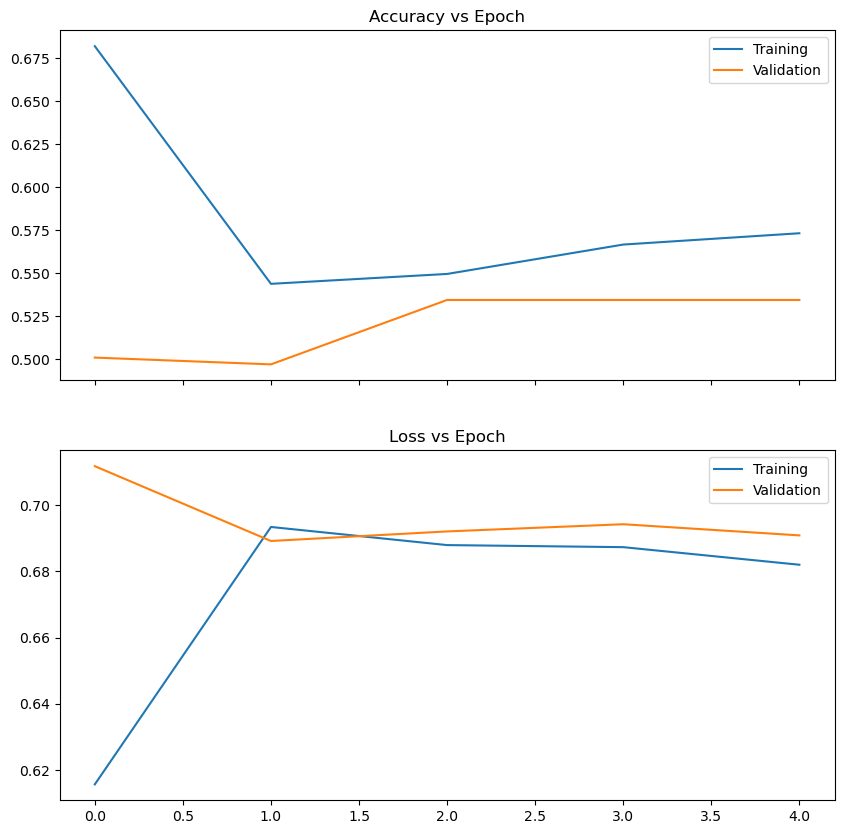

In [23]:
# Model evaluation graphs
# Model evaluation
fig = plt.figure(figsize=(10,10))
axes = fig.subplots(nrows=2, ncols=1, sharex=True)
axes[0].plot(simplernn_results.history['accuracy'])
axes[0].plot(simplernn_results.history['val_accuracy'])
#axes[0].set_ylim([0,1.])
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Accuracy vs Epoch")

axes[1].plot(simplernn_results.history['loss'])
axes[1].plot(simplernn_results.history['val_loss'])
#axes[1].set_ylim([0,1.])
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Loss vs Epoch")

plt.show()

#### Results and Analysis for SimpleRNN

From our graphs, we can see that the training data experienced a sharp decline in accuracy while the validation data trended up and then leveled out. This was performed over 5 epochs.  

| Type | Final Accuracy |
|---|---|
| Training | 0.5732 |
| Validation | 0.5345 |  

This is not a particularly fantastic result and we will seek to improve it in the next model and with hyperparameter tuning.

In model 2 we will look to use the LSTM RNN cell type while keeping everything else the same. We should expect this to run faster as well as up our accuracy.

### Model 2: LSTM (Long Short-Term Memory)

In [24]:
model_LSTM = Sequential()
model_LSTM.add(keras.Input(shape=(1,), dtype=tf.string))
model_LSTM.add(text_vectorization)
model_LSTM.add(Embedding(
    input_dim=len(vocab_dict)+1,
    output_dim=200,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False
))
model_LSTM.add(keras.layers.LSTM(units=128, return_sequences=False))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 54)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 54, 200)           1000200   
                                                                 
 lstm (LSTM)                 (None, 128)               168448    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,168,777
Trainable params: 168,577
Non-trainable params: 1,000,200
_________________________________________________________________


In [25]:
# Compile and fit model_simplernn
model_LSTM.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

LSTM_results = model_LSTM.fit(
    tweet_training_data.text, 
    tweet_training_data.target, 
    validation_split=0.2, 
    epochs=5
)

Epoch 1/5


2023-04-20 18:22:56.930610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-20 18:22:57.100060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-20 18:22:57.313859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - ETA: 0s - loss: 0.6412 - accuracy: 0.6483

2023-04-20 18:23:02.173347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-20 18:23:02.242924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - 7s 28ms/step - loss: 0.6412 - accuracy: 0.6483 - val_loss: 0.6035 - val_accuracy: 0.7334
Epoch 2/5
191/191 [==============================] - 5s 25ms/step - loss: 0.6316 - accuracy: 0.6652 - val_loss: 0.6278 - val_accuracy: 0.6500
Epoch 3/5
191/191 [==============================] - 5s 25ms/step - loss: 0.6687 - accuracy: 0.6049 - val_loss: 0.6978 - val_accuracy: 0.5345
Epoch 4/5
191/191 [==============================] - 5s 25ms/step - loss: 0.6824 - accuracy: 0.5793 - val_loss: 0.7082 - val_accuracy: 0.5345
Epoch 5/5
191/191 [==============================] - 5s 24ms/step - loss: 0.6815 - accuracy: 0.5828 - val_loss: 0.6914 - val_accuracy: 0.5345


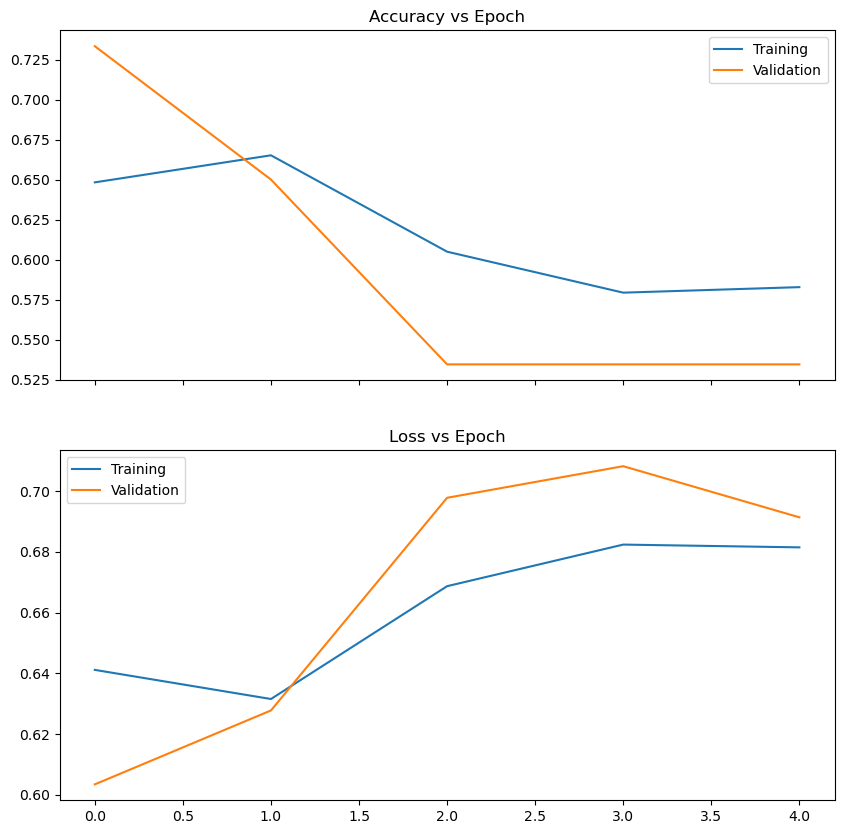

In [29]:
# Model evaluation graphs
# Model evaluation
fig = plt.figure(figsize=(10,10))
axes = fig.subplots(nrows=2, ncols=1, sharex=True)
axes[0].plot(LSTM_results.history['accuracy'])
axes[0].plot(LSTM_results.history['val_accuracy'])
#axes[0].set_ylim([0,1.])
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Accuracy vs Epoch")

axes[1].plot(LSTM_results.history['loss'])
axes[1].plot(LSTM_results.history['val_loss'])
#axes[1].set_ylim([0,1.])
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Loss vs Epoch")

plt.show()

#### Results and Analysis for LSTM

We did see a very large accuracy increase initially using the LSTM model, and then a precipitous fall down to levels that are not really better than SimpleRNN. This might hint at the notion that RNN models do not need a large amount of epochs to train weights.  We will explore this in the hyperparameter tuning section.  

One interesting note though is the run time associated with these. My model involving SimpleRNN over ten minutes to run while the LSTM model took less than 30 seconds.

| Type | Final Accuracy |
|---|---|
| Training | 0.5828 |
| Validation | 0.5345 |  

One good thing about LSTM models is that you can stack the layers to get better results. I will attempt to do this in the next and final model stacking 3 LSTM layers. I will also introduct a slight dropout to avoid overfitting.

### Model 3: LSTM x3

In [27]:
model_LSTMx3 = Sequential()
model_LSTMx3.add(keras.Input(shape=(1,), dtype=tf.string))
model_LSTMx3.add(text_vectorization)
model_LSTMx3.add(Embedding(
    input_dim=len(vocab_dict)+1,
    output_dim=200,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False
))
model_LSTMx3.add(keras.layers.LSTM(units=128, return_sequences=True, dropout=0.1))
model_LSTMx3.add(keras.layers.LSTM(units=128, return_sequences=True, dropout=0.1))
model_LSTMx3.add(keras.layers.LSTM(units=128, return_sequences=False))
model_LSTMx3.add(Dense(1, activation='sigmoid'))
model_LSTMx3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 54)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 54, 200)           1000200   
                                                                 
 lstm_1 (LSTM)               (None, 54, 128)           168448    
                                                                 
 lstm_2 (LSTM)               (None, 54, 128)           131584    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                      

In [28]:
# Compile and fit model_simplernn
model_LSTMx3.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

LSTMx3_results = model_LSTMx3.fit(
    tweet_training_data.text, 
    tweet_training_data.target, 
    validation_split=0.2, 
    epochs=5
)

Epoch 1/5


2023-04-20 18:30:40.293901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-20 18:30:40.700162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-20 18:30:40.819720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-20 18:30:40.921155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-20 18:30:41.083441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-20 18:30:41.264204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/191 [..............................] - ETA: 7:38 - loss: 0.6934 - accuracy: 0.5312

2023-04-20 18:30:41.471599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - ETA: 0s - loss: 0.5724 - accuracy: 0.7309

2023-04-20 18:30:51.407557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-20 18:30:51.562659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-20 18:30:51.665293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-20 18:30:51.766519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - 14s 61ms/step - loss: 0.5724 - accuracy: 0.7309 - val_loss: 0.5356 - val_accuracy: 0.7511
Epoch 2/5
191/191 [==============================] - 10s 53ms/step - loss: 0.5702 - accuracy: 0.7309 - val_loss: 0.5915 - val_accuracy: 0.7275
Epoch 3/5
191/191 [==============================] - 10s 52ms/step - loss: 0.6090 - accuracy: 0.6800 - val_loss: 0.6358 - val_accuracy: 0.6448
Epoch 4/5
191/191 [==============================] - 10s 54ms/step - loss: 0.6246 - accuracy: 0.6622 - val_loss: 0.6145 - val_accuracy: 0.6645
Epoch 5/5
191/191 [==============================] - 10s 54ms/step - loss: 0.6171 - accuracy: 0.6790 - val_loss: 0.5668 - val_accuracy: 0.7413


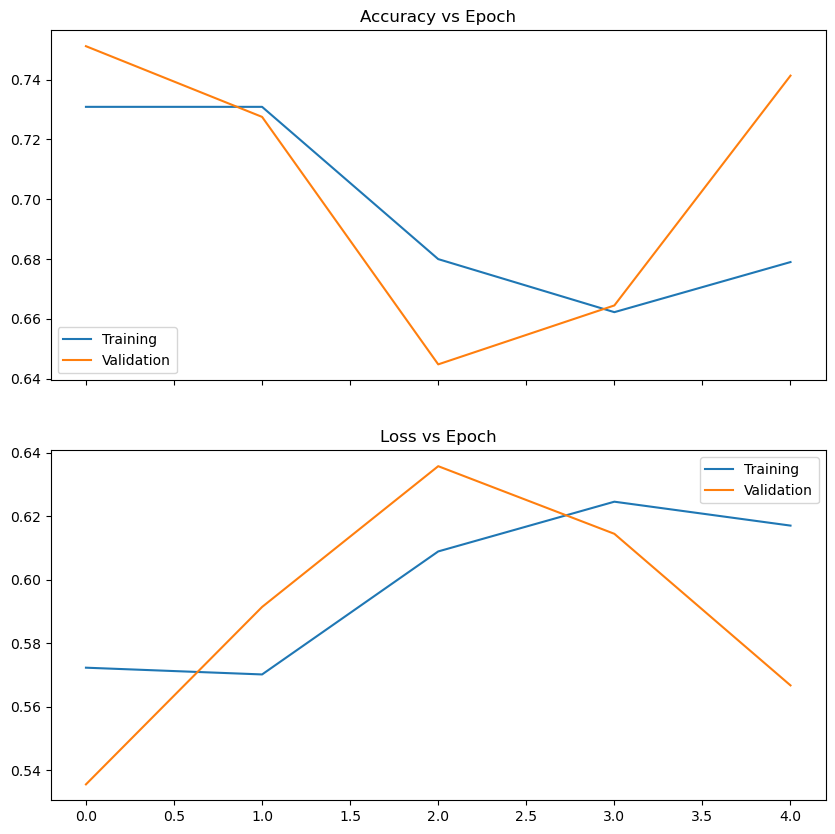

In [30]:
# Model evaluation graphs
# Model evaluation
fig = plt.figure(figsize=(10,10))
axes = fig.subplots(nrows=2, ncols=1, sharex=True)
axes[0].plot(LSTMx3_results.history['accuracy'])
axes[0].plot(LSTMx3_results.history['val_accuracy'])
#axes[0].set_ylim([0,1.])
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Accuracy vs Epoch")

axes[1].plot(LSTMx3_results.history['loss'])
axes[1].plot(LSTMx3_results.history['val_loss'])
#axes[1].set_ylim([0,1.])
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Loss vs Epoch")

plt.show()

#### Results and Analysis for LSTMx3

This is especially interesting as we see a fairly storng accuracy and then a dip and then an increase. Next we will explore how epochs effect accuracy over a lot of epochs to get an idea of what is going on.

| Type | Final Accuracy |
|---|---|
| Training | 0.6622 |
| Validation | 0.6645 |  

### Hyperparameter Tuning: Epochs  

We have seen some interesting effects of accuracy bouncing around even across 5 epochs. I am next going to use the LSTMx3 model and explore what happens as epochs go out to 25 trials.

In [31]:
# Model LSTMx3 Epoch tuning
LSTMx3_epoch_results = model_LSTMx3.fit(
    tweet_training_data.text, 
    tweet_training_data.target, 
    validation_split=0.2, 
    epochs=25
)

Epoch 1/25
191/191 [==============================] - 10s 53ms/step - loss: 0.5909 - accuracy: 0.7117 - val_loss: 0.5925 - val_accuracy: 0.7590
Epoch 2/25
191/191 [==============================] - 10s 53ms/step - loss: 0.5489 - accuracy: 0.7479 - val_loss: 0.5047 - val_accuracy: 0.7702
Epoch 3/25
191/191 [==============================] - 10s 52ms/step - loss: 0.4969 - accuracy: 0.7803 - val_loss: 0.4918 - val_accuracy: 0.7722
Epoch 4/25
191/191 [==============================] - 10s 53ms/step - loss: 0.4634 - accuracy: 0.8000 - val_loss: 0.4371 - val_accuracy: 0.7945
Epoch 5/25
191/191 [==============================] - 10s 53ms/step - loss: 0.4471 - accuracy: 0.8094 - val_loss: 0.4276 - val_accuracy: 0.8030
Epoch 6/25
191/191 [==============================] - 10s 53ms/step - loss: 0.4258 - accuracy: 0.8197 - val_loss: 0.4144 - val_accuracy: 0.8109
Epoch 7/25
191/191 [==============================] - 10s 52ms/step - loss: 0.4142 - accuracy: 0.8273 - val_loss: 0.4182 - val_accuracy:

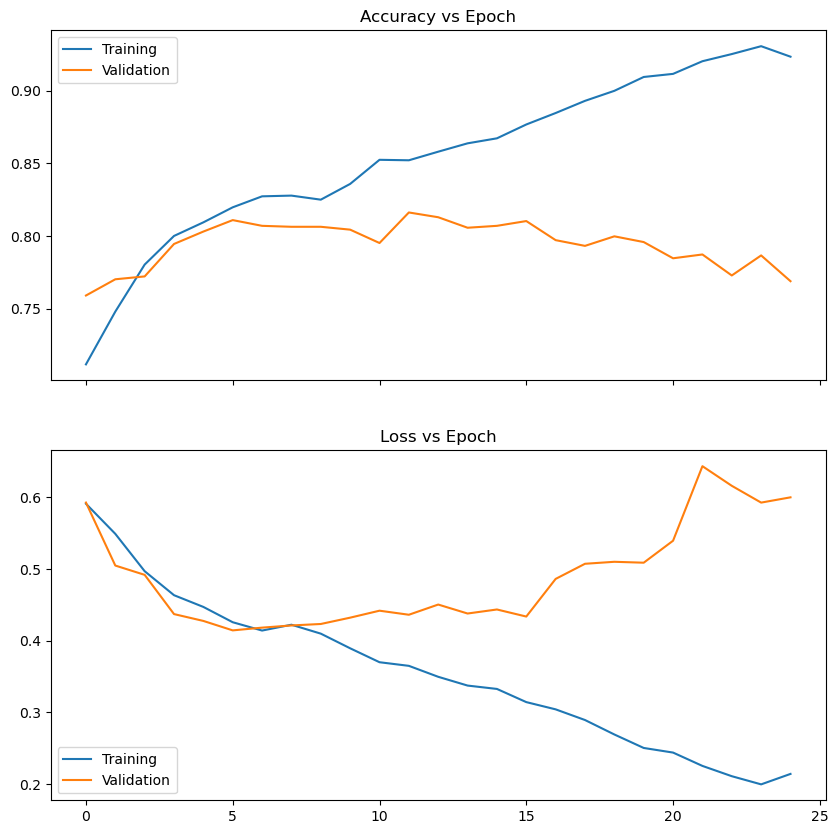

In [32]:
# Model evaluation
fig = plt.figure(figsize=(10,10))
axes = fig.subplots(nrows=2, ncols=1, sharex=True)
axes[0].plot(LSTMx3_epoch_results.history['accuracy'])
axes[0].plot(LSTMx3_epoch_results.history['val_accuracy'])
#axes[0].set_ylim([0,1.])
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Accuracy vs Epoch")

axes[1].plot(LSTMx3_epoch_results.history['loss'])
axes[1].plot(LSTMx3_epoch_results.history['val_loss'])
#axes[1].set_ylim([0,1.])
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Loss vs Epoch")

plt.show()

#### Hyperparameter Tuning Analysis  

After performing this analysis, it appears that the sweet spot for epoch valuation at least for our learning rate samples is around 5. Beyond that, the accuracy associated with the validation data seems to level out such that it is wasted effort.

We will use this final model to make predictions for submission

## Conclusions  

In this project, we saw that vast improvements that using more recent advanced neural network models can obtain. We went from an intial accuracy slightly better than 50% with a SimpleRNN to one that scored close to 80% in the submission for this project using multiple LSTM layers.  

And this only scratched the surface. During my research for this project, I stumbled upon references that mentioned using convolution and max pooling layers in combination with RNN layers to yield better results.  

Experimenting with these methods as well as other combinations of layers and learning rates could be an avenue to improve the performance of the models even further!

## Predictions and Submissions

In [33]:
model_predictions = model_LSTMx3.predict(tweet_test_data.text)

2023-04-20 18:47:55.464808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-20 18:47:55.606642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-20 18:47:55.731674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-20 18:47:55.836127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


102/102 [==============================] - 3s 25ms/step


In [46]:
prediction_results = pd.DataFrame({"id": tweet_test_data.id,
                                   "target": (model_predictions > 0.5).astype("int").flatten()})

In [48]:
prediction_results.to_csv("NLP Disaster Predictions.csv", index=False)

## Sources  

* [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/)
* [Intuitive Guide to Understanding GloVe Embeddings](https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010)
* [GloVe Vectors](https://nlp.stanford.edu/projects/glove/)
* [TextVectorization](https://towardsdatascience.com/you-should-try-the-new-tensorflows-textvectorization-layer-a80b3c6b00ee)